# EEE3314-02, Introduction Artificial Intelligence
# Lecture 6. Object Detection (YOLO 모델 구현하기)

#1. Network design
YOLO 논문에 있는 네트워크를 구현하기


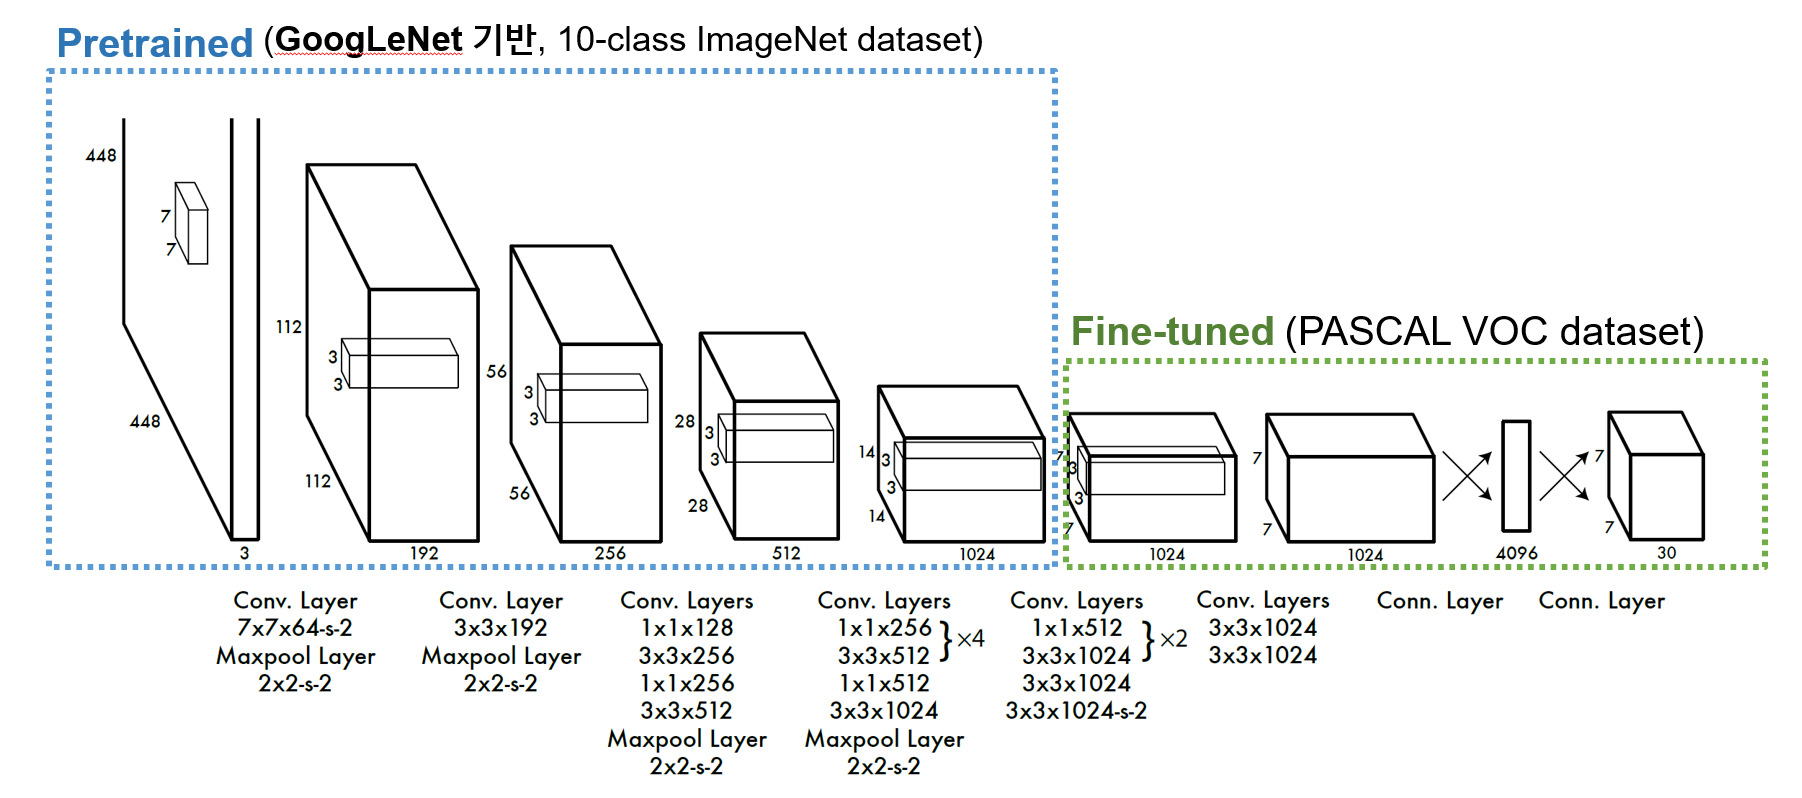

In [ ]:
import torch
import torch.nn as nn

In [ ]:
""" 
architecture config (list):
각 tuple은 convolutional layer (kernel_size, filters, stride, padding)를 의미
"M" 은 max pooling을 의미 (2x2 stride with 2x2 kernel)
각 list는 반복되는 convolutional layers의 정보를 담고 있음. 반복해야하는 convolutional layers (tuple)과 반복 횟수 (int)로 구성되어 있음
"""
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

# 각 convolutional layer를 생성 (torch.nn.Module을 상속 받음. layer를 정의하고 'forward'함수에 forward pass를 설정하면 나중에 backpropagation을 계산해 줌)
class CNNBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, **kwargs): # in_channel과 out_channel 및 나머지 요소들 (kernel size, padding, stride 등)은 keyword arguments로 입력 받음
        super(CNNBlock, self).__init__() # 현재 class를 상속받기 (class initialize할 때, 보통 고정적으로 사용됨)
        
        # conv. layer 추가 (batch norm 사용시에는 보통 bias = False)
        # batchnorm 추가 (yolo 본 논문에는 없지만, 이 당시 batch norm이 없었음. 성능 향상을 위해 추가)
        # activation function은 leaky relu (slope=0.1)
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs) 
        self.batchnorm = nn.BatchNorm2d(out_channels) 
        self.leakyrelu = nn.LeakyReLU(0.1) 

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x))) # conv -> batchnorm -> leakyrelu 순으로 forward pass

# YOLO 모델 생성
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels

        # convolutional layers 부분을 정의. YOLO 저자가 해당 CNN을 darknet이라고 명명
        self.darknet = self._create_conv_layers(self.architecture) 
        self.fcs = self._create_fcs(**kwargs)

    # YOLO 모델의 forward pass: darknet(Conv. layers) + FC layers
    def forward(self, x):
        x = self.darknet(x) # convolutional layers 부분
        x = self.fcs(torch.flatten(x, start_dim=1)) # 이후 FC 를 통과시키는 부분
        return x 

    # architecture_config를 입력으로 받아서, 그에 해당하는 conv. layers를 출력하는 함수
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels # 처음 in_channel = 3 (RGB)

        # architecture_config (list) 에서 각 network component를 하나씩 불러옴
        for x in architecture:
            if type(x) == tuple: # one convolutional layer를 의미
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3], # configuration에 해당하는 convolutional layer를 추가
                    )
                ]
                in_channels = x[1] # 다음 layer의 in_channel을 현재 추가한 convolutional layer의 out_channel로 변경

            elif type(x) == str: # "M", 즉 max pooling layer
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))] # max pooling layer 추가

            elif type(x) == list:
                conv1 = x[0] # tuple
                conv2 = x[1] # tuple
                num_repeats = x[2] # int

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1] #다음 layer의 in_channel을 마지막 layer을 out_channel로 변경

        return nn.Sequential(*layers) # nn.Sequential: list 형태의 layers를 하나로 묶는 함수

    def _create_fcs(self, split_size, num_boxes, num_classes): # yolo 모델의 마지막 단인 Fully-connected layers를 생성하는 함수
        S, B, C = split_size, num_boxes, num_classes

        return nn.Sequential(
            nn.Flatten(), # (7, 7, 1024) -> (7*7*1024)
            nn.Linear(7*7*1024, 4096), # (7*7*1024 -> 4096)
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (B * 5 + C)), # (4096 -> 7*7*30)
        )

***Network를 선언(초기화)하고, 간단한  Sanity check 하기***

In [ ]:
BATCH_SIZE = 4
SPLIT_SIZE = 5 # S (grid size = S*S)
NUM_BOXES = 3 # B (각 cell에서 출력하는 box 개수)
NUM_CLASSES = 10 # C (총 class의 개수)

model = Yolov1(split_size=SPLIT_SIZE, num_boxes=NUM_BOXES, num_classes=NUM_CLASSES) # Model 초기화 (Yolov1 class의 __init__에 해당)
x = torch.randn((BATCH_SIZE, 3, 448, 448)) # (batch size, RGB channels, width, height)
print(f"YOLO model의 expected output tensor ({BATCH_SIZE}, {SPLIT_SIZE**2*(NUM_BOXES*5+NUM_CLASSES)}): {model(x).shape}") # output tensor의 size를 출력 (batch size, S*S*(B*5+C))

#2. Loss function
YOLO 논문에 있는 Loss function을 구현하기

***먼저 2개의 box 중에서 가장 IoU가 높은 box를 선택하기 위해서 IoU 함수가 필요 (지난 시간에 구현)***

In [ ]:
def calculate_iou(boxes_preds, boxes_labels, box_type="midpoint"):
    if box_type == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_type == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2-x1).clamp(0) * (y2-y1).clamp(0)
    
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    union = (box1_area + box2_area - intersection).clamp(1e-6)

    results = intersection / union

    return results

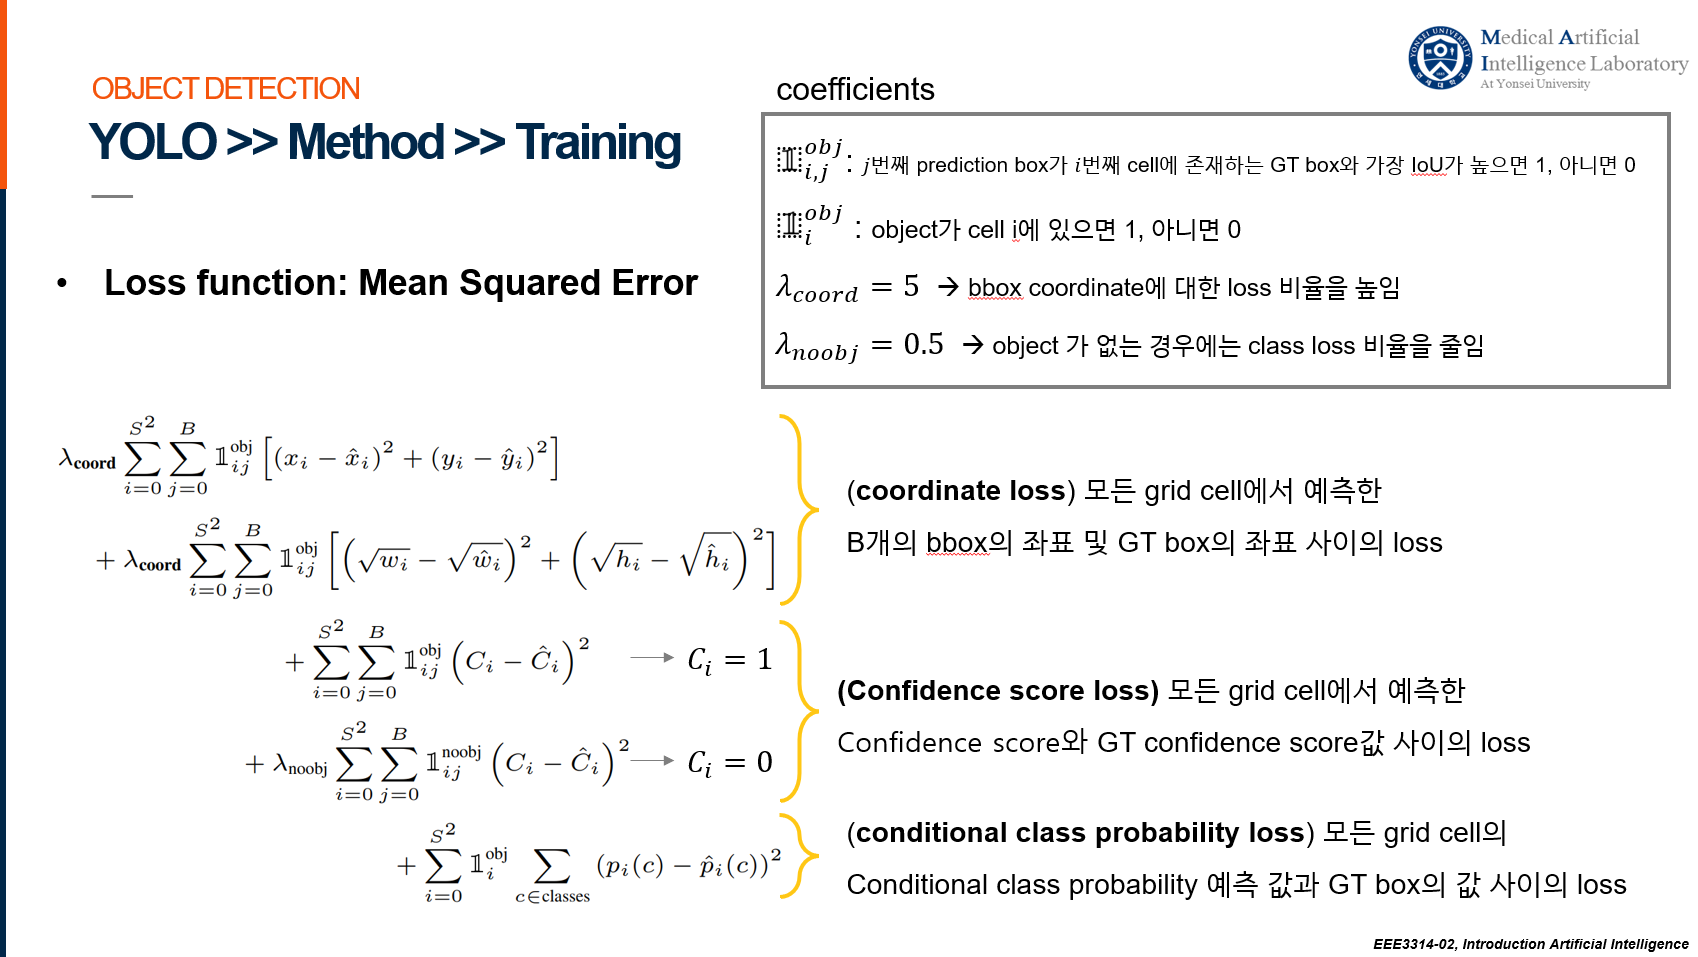

***Loss function 구현***

In [ ]:
class YoloLoss(nn.Module):
    """
    yolo(v1) model의 loss 구현하기
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum") # 평균 취하지 않고, sum

        """
        S is split size of image (paper에서는 7),
        B is number of boxes (paper에서는 2),
        C is number of classes (paper에서는 is 20 -> VOC dataset의 class 개수),
        """
        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # 여기서 model의 output size를 (7*7*30)에서 (7, 7, 30)으로 변경
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Ground truth 박스와 predicted box 간의 IoU를 계산
        iou_b1 = intersection_over_union(predictions[..., 0:4], target[..., 0:4])
        iou_b2 = intersection_over_union(predictions[..., 5:9], target[..., 0:4])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # 두 개의 predicted box 중에서 더 IoU가 높은 box를 남긴다.
        # bestbox가 해당 box의 index (B=2이므로, 0 or 1)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 4].unsqueeze(3)  # object가 cell i에 존재하는지 여부. 논문에서는 Iobj_i. 존재하면 1 아니면 0. 

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # 2개 중 IoU가 높은 box의 bbox coordinate를 가져옴 (box predictions). 이 때 박스가 존재 하지 않으면, 0으로 처리
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 5:9]
                + (1 - bestbox) * predictions[..., 0:4]
            )
        )

        # 마찬가지로 GT box에 대해서도 box coordinate를 가져옴.
        box_targets = exists_box * target[..., 0:4]

        # w, h에 대한 loss 계산을 위해서 sqrt를 씌움. inf loss 방지를 위해 1e-6을 더함
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        # box coordinate에 대한 최종 loss / exist_box = 0이면 항상 loss는 0
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ====================================== #
        #   FOR OBJECT LOSS (confidence socre)   #
        # ====================================== #

        # pred_box는 bbox 중에서 높은 IoU를 갖는 box의 confidence score
        pred_box = (
            bestbox * predictions[..., 9:10] + (1 - bestbox) * predictions[..., 4:5]
        )

        # confidence score간의 mse loss. 물체가 존재한다면 GT confidence score = 1
        # 물체가 존재 하는 prediction의 confidence score를 1에 가깝게 만드는 loss
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 4:5]),
        )

        # ======================================== #
        #   FOR NO OBJECT LOSS (confidence socre)  #
        # ======================================== #

       # confidence score간의 mse loss. 물체가 존재하지 않는다면, GT confidence score = 0
       # 물체가 존재 하지 않는 prediction의 confidence score를 0으로 가깝게 만드는 loss
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 4:5], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 4:5], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 9:10], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 4:5], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        # 길이 20의 conditional class probability에 대한 loss (물체가 있는 경우만 계산. 없으면 0)
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., 10:], end_dim=-2,),
            torch.flatten(exists_box * target[..., 10:], end_dim=-2,),
        )

        # Final loss (5개의 loss항을 전부 더한 것)
        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss